# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import vaep
import vaep.analyzers
import vaep.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
vaep.plotting.make_large_descriptors(fontsize)


logger = vaep.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "CF"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = vaep.nb.get_params(args, globals=globals())
args = vaep.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = vaep.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'CF',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = vaep.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

vaep.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


vaep.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


vaep.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups                          
Sample_120  O43291                                     18.401
Sample_117  A0A0A0MTP9;F8VZI9;Q9BWQ8                   17.669
Sample_138  P07585                                     18.893
Sample_188  Q5BIV9                                     17.397
Sample_116  H3BMA1;H3BUX1;Q13421-2;Q13421-3;Q13421-4   15.742
Name: intensity, dtype: float64

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = vaep.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[vaep.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = vaep.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by CF: runs/alzheimer_study/preds/pred_real_na_CF.csv


Sample ID   protein groups                     
Sample_077  A0A1W2PQ94;B4DS77;B4DS77-2;B4DS77-3   13.045
Sample_129  Q15121;Q15121-2                       12.698
Sample_044  P05023;P05023-4                       14.435
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 11.698
            A0A075B6Q5                 11.606
            A0A075B6R2                 13.068
            A0A075B6S5                 13.623
            A0A087WSY4                 13.272
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   11.434
            Q9UI40;Q9UI40-2            12.672
            Q9UIW2                     12.425
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   12.199
            Q9UP79                     12.618
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,14.476,15.050,16.842,19.863,16.000,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,16.699,19.067,...,15.528,15.576,14.652,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,15.629,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,14.648,17.705,17.039,15.035,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,15.162,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,15.221,15.345,17.084,18.708,14.249,19.433,12.072,11.259
Sample_207,15.739,16.877,15.469,16.898,14.474,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,11.698,...,16.012,15.178,12.706,15.050,16.842,19.863,12.769,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,11.862,19.067,16.188,...,15.528,15.576,11.936,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,12.926,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,13.027,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,12.378,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,12.919,15.345,17.084,18.708,14.249,19.433,12.183,12.181
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 352.55it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  3.32it/s]

100%|██████████| 2/2 [00:00<00:00,  3.24it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  4.90it/s]

100%|██████████| 3/3 [00:00<00:00,  3.29it/s]

100%|██████████| 3/3 [00:00<00:00,  3.51it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  4.98it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  3.68it/s]

100%|██████████| 4/4 [00:01<00:00,  2.98it/s]

100%|██████████| 4/4 [00:01<00:00,  3.28it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  3.87it/s]

 60%|██████    | 3/5 [00:00<00:00,  3.29it/s]

 80%|████████  | 4/5 [00:01<00:00,  3.11it/s]

100%|██████████| 5/5 [00:01<00:00,  2.87it/s]

100%|██████████| 5/5 [00:01<00:00,  3.04it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  5.88it/s]

 50%|█████     | 3/6 [00:00<00:00,  4.16it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.90it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  2.43it/s]

100%|██████████| 6/6 [00:02<00:00,  2.19it/s]

100%|██████████| 6/6 [00:02<00:00,  2.61it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  5.02it/s]

 43%|████▎     | 3/7 [00:00<00:01,  3.23it/s]

 57%|█████▋    | 4/7 [00:01<00:01,  2.61it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  2.68it/s]

 86%|████████▌ | 6/7 [00:02<00:00,  2.71it/s]

100%|██████████| 7/7 [00:02<00:00,  2.74it/s]

100%|██████████| 7/7 [00:02<00:00,  2.86it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00,  6.02it/s]

 38%|███▊      | 3/8 [00:00<00:01,  4.32it/s]

 50%|█████     | 4/8 [00:01<00:01,  3.64it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  3.28it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  2.94it/s]

 88%|████████▊ | 7/8 [00:02<00:00,  2.81it/s]

100%|██████████| 8/8 [00:02<00:00,  2.40it/s]

100%|██████████| 8/8 [00:02<00:00,  2.94it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  5.28it/s]

 33%|███▎      | 3/9 [00:00<00:01,  3.94it/s]

 44%|████▍     | 4/9 [00:00<00:01,  3.98it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  3.75it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  3.61it/s]

 78%|███████▊  | 7/9 [00:01<00:00,  3.23it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  3.06it/s]

100%|██████████| 9/9 [00:02<00:00,  3.03it/s]

100%|██████████| 9/9 [00:02<00:00,  3.40it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  7.13it/s]

 30%|███       | 3/10 [00:00<00:01,  4.49it/s]

 40%|████      | 4/10 [00:00<00:01,  3.72it/s]

 50%|█████     | 5/10 [00:01<00:01,  2.91it/s]

 60%|██████    | 6/10 [00:02<00:01,  2.42it/s]

 70%|███████   | 7/10 [00:02<00:01,  2.14it/s]

 80%|████████  | 8/10 [00:03<00:00,  2.00it/s]

 90%|█████████ | 9/10 [00:03<00:00,  2.04it/s]

100%|██████████| 10/10 [00:04<00:00,  2.14it/s]

100%|██████████| 10/10 [00:04<00:00,  2.47it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:02,  3.75it/s]

 27%|██▋       | 3/11 [00:01<00:03,  2.65it/s]

 36%|███▋      | 4/11 [00:01<00:02,  2.58it/s]

 45%|████▌     | 5/11 [00:01<00:02,  2.74it/s]

 55%|█████▍    | 6/11 [00:02<00:01,  2.75it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  2.83it/s]

 73%|███████▎  | 8/11 [00:02<00:01,  2.73it/s]

 82%|████████▏ | 9/11 [00:03<00:00,  2.71it/s]

 91%|█████████ | 10/11 [00:03<00:00,  2.67it/s]

100%|██████████| 11/11 [00:04<00:00,  2.67it/s]

100%|██████████| 11/11 [00:04<00:00,  2.74it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  7.21it/s]

 25%|██▌       | 3/12 [00:00<00:01,  5.24it/s]

 33%|███▎      | 4/12 [00:00<00:01,  4.49it/s]

 42%|████▏     | 5/12 [00:01<00:01,  3.60it/s]

 50%|█████     | 6/12 [00:01<00:01,  3.63it/s]

 58%|█████▊    | 7/12 [00:01<00:01,  3.50it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  3.36it/s]

 75%|███████▌  | 9/12 [00:02<00:01,  2.96it/s]

 83%|████████▎ | 10/12 [00:02<00:00,  3.01it/s]

 92%|█████████▏| 11/12 [00:03<00:00,  3.05it/s]

100%|██████████| 12/12 [00:03<00:00,  3.12it/s]

100%|██████████| 12/12 [00:03<00:00,  3.46it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  6.73it/s]

 23%|██▎       | 3/13 [00:00<00:01,  5.03it/s]

 31%|███       | 4/13 [00:00<00:01,  4.51it/s]

 38%|███▊      | 5/13 [00:01<00:01,  4.05it/s]

 46%|████▌     | 6/13 [00:01<00:02,  3.38it/s]

 54%|█████▍    | 7/13 [00:01<00:01,  3.25it/s]

 62%|██████▏   | 8/13 [00:02<00:01,  3.32it/s]

 69%|██████▉   | 9/13 [00:02<00:01,  3.10it/s]

 77%|███████▋  | 10/13 [00:02<00:00,  3.28it/s]

 85%|████████▍ | 11/13 [00:03<00:00,  3.33it/s]

 92%|█████████▏| 12/13 [00:03<00:00,  3.17it/s]

100%|██████████| 13/13 [00:03<00:00,  3.11it/s]

100%|██████████| 13/13 [00:03<00:00,  3.47it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:01,  6.84it/s]

 21%|██▏       | 3/14 [00:00<00:02,  4.36it/s]

 29%|██▊       | 4/14 [00:01<00:02,  3.44it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.36it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.28it/s]

 50%|█████     | 7/14 [00:01<00:02,  3.30it/s]

 57%|█████▋    | 8/14 [00:02<00:01,  3.28it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  3.13it/s]

 71%|███████▏  | 10/14 [00:03<00:01,  2.89it/s]

 79%|███████▊  | 11/14 [00:03<00:01,  2.93it/s]

 86%|████████▌ | 12/14 [00:03<00:00,  2.92it/s]

 93%|█████████▎| 13/14 [00:04<00:00,  2.94it/s]

100%|██████████| 14/14 [00:04<00:00,  3.03it/s]

100%|██████████| 14/14 [00:04<00:00,  3.21it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  5.79it/s]

 20%|██        | 3/15 [00:00<00:02,  4.08it/s]

 27%|██▋       | 4/15 [00:01<00:03,  3.49it/s]

 33%|███▎      | 5/15 [00:01<00:03,  2.71it/s]

 40%|████      | 6/15 [00:01<00:03,  2.74it/s]

 47%|████▋     | 7/15 [00:02<00:02,  2.78it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  2.88it/s]

 60%|██████    | 9/15 [00:02<00:01,  3.04it/s]

 67%|██████▋   | 10/15 [00:03<00:01,  3.04it/s]

 73%|███████▎  | 11/15 [00:03<00:01,  2.90it/s]

 80%|████████  | 12/15 [00:03<00:00,  3.00it/s]

 87%|████████▋ | 13/15 [00:04<00:00,  2.81it/s]

 93%|█████████▎| 14/15 [00:04<00:00,  2.82it/s]

100%|██████████| 15/15 [00:04<00:00,  2.87it/s]

100%|██████████| 15/15 [00:04<00:00,  3.00it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.006 0.005      0.061 0.025          0.705 0.393       0.098   
2             0.004 0.002      0.056 0.019          0.666 0.100       0.529   
3             0.005 0.004      0.071 0.028          0.758 0.095       0.674   
4             0.005 0.003      0.068 0.026          0.754 0.094       0.712   
5             0.005 0.003      0.055 0.017          0.795 0.083       0.738   
6             0.005 0.004      0.065 0.028          0.811 0.079       0.743   
7             0.004 0.002      0.074 0.031          0.811 0.082       0.747   
8             0.006 0.004      0.067 0.024          0.820 0.083       0.833   
9             0.006 0.005      0.065 0.024          0.823 0.081       0.837   
10            0.005 0.005      0.057 0.019          0.827 0.080       0.831   
11            0.005 0.003      0.055 0.015          0.816 0.086       0.822   
12            0.004 0.001      0.050 0.012          0.813 0.089       0.821   
13            0.004 0.001      0.048 0.013          0.810 0.084       0.819   
14            0.005 0.003      0.052 0.012          0.805 0.083       0.818   
15            0.005 0.003      0.051 0.011          0.820 0.073       0.810   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.078   0.167 0.120                  0.542 0.036        0.850   
2          0.107   0.581 0.077                  0.663 0.052        0.730   
3          0.124   0.707 0.088                  0.756 0.069        0.830   
4          0.131   0.724 0.089                  0.769 0.069        0.842   
5          0.090   0.761 0.066                  0.798 0.053        0.858   
6          0.082   0.772 0.061                  0.807 0.050        0.865   
7          0.089   0.773 0.064                  0.808 0.052        0.863   
8          0.098   0.822 0.065                  0.848 0.056        0.910   
9          0.103   0.825 0.069                  0.851 0.060        0.910   
10         0.103   0.824 0.066                  0.850 0.056        0.909   
11         0.109   0.813 0.073                  0.841 0.062        0.907   
12         0.109   0.812 0.075                  0.840 0.064        0.906   
13         0.103   0.810 0.071                  0.837 0.061        0.904   
14         0.103   0.807 0.072                  0.835 0.062        0.903   
15         0.104   0.810 0.068                  0.839 0.057        0.909   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.064                  0.823 0.089        210.000 0.000  
2          0.073                  0.669 0.090        210.000 0.000  
3          0.065                  0.807 0.079        210.000 0.000  
4          0.061                  0.826 0.065        210.000 0.000  
5          0.061                  0.846 0.069        210.000 0.000  
6          0.062                  0.846 0.072        210.000 0.000  
7          0.062                  0.844 0.071        210.000 0.000  
8          0.049                  0.899 0.050        210.000 0.000  
9          0.050                  0.900 0.051        210.000 0.000  
10         0.050                  0.896 0.054        210.000 0.000  
11         0.051                  0.894 0.054        210.000 0.000  
12         0.051                  0.894 0.053        210.000 0.000  
13         0.052                  0.890 0.055        210.000 0.000  
14         0.051                  0.888 0.055        210.000 0.000  
15         0.050                  0.891 0.055 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 467.75it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  5.65it/s]

100%|██████████| 2/2 [00:00<00:00,  5.61it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  5.29it/s]

100%|██████████| 3/3 [00:00<00:00,  3.92it/s]

100%|██████████| 3/3 [00:00<00:00,  4.12it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  5.48it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  3.98it/s]

100%|██████████| 4/4 [00:01<00:00,  3.00it/s]

100%|██████████| 4/4 [00:01<00:00,  3.37it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  4.59it/s]

 60%|██████    | 3/5 [00:00<00:00,  2.80it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.24it/s]

100%|██████████| 5/5 [00:02<00:00,  1.86it/s]

100%|██████████| 5/5 [00:02<00:00,  2.18it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:01,  3.02it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.36it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.18it/s]

 83%|████████▎ | 5/6 [00:02<00:00,  2.35it/s]

100%|██████████| 6/6 [00:02<00:00,  2.35it/s]

100%|██████████| 6/6 [00:02<00:00,  2.38it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  5.58it/s]

 43%|████▎     | 3/7 [00:00<00:01,  3.89it/s]

 57%|█████▋    | 4/7 [00:01<00:00,  3.21it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  2.43it/s]

 86%|████████▌ | 6/7 [00:02<00:00,  2.13it/s]

100%|██████████| 7/7 [00:02<00:00,  2.00it/s]

100%|██████████| 7/7 [00:02<00:00,  2.42it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00,  9.16it/s]

 38%|███▊      | 3/8 [00:00<00:00,  5.30it/s]

 50%|█████     | 4/8 [00:00<00:00,  4.64it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  3.92it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  3.61it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  3.61it/s]

100%|██████████| 8/8 [00:01<00:00,  3.82it/s]

100%|██████████| 8/8 [00:01<00:00,  4.13it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:00,  7.53it/s]

 33%|███▎      | 3/9 [00:00<00:01,  5.51it/s]

 44%|████▍     | 4/9 [00:00<00:01,  4.42it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  3.87it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  3.50it/s]

 78%|███████▊  | 7/9 [00:01<00:00,  3.13it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  2.98it/s]

100%|██████████| 9/9 [00:02<00:00,  2.94it/s]

100%|██████████| 9/9 [00:02<00:00,  3.47it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:00,  9.10it/s]

 30%|███       | 3/10 [00:00<00:01,  6.35it/s]

 40%|████      | 4/10 [00:00<00:01,  5.66it/s]

 50%|█████     | 5/10 [00:00<00:00,  5.03it/s]

 60%|██████    | 6/10 [00:01<00:00,  4.83it/s]

 70%|███████   | 7/10 [00:01<00:00,  4.80it/s]

 80%|████████  | 8/10 [00:01<00:00,  4.72it/s]

 90%|█████████ | 9/10 [00:01<00:00,  4.62it/s]

100%|██████████| 10/10 [00:01<00:00,  4.70it/s]

100%|██████████| 10/10 [00:01<00:00,  5.05it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:00,  9.37it/s]

 27%|██▋       | 3/11 [00:00<00:01,  6.55it/s]

 36%|███▋      | 4/11 [00:00<00:01,  5.79it/s]

 45%|████▌     | 5/11 [00:00<00:01,  5.33it/s]

 55%|█████▍    | 6/11 [00:01<00:00,  5.06it/s]

 64%|██████▎   | 7/11 [00:01<00:00,  5.22it/s]

 73%|███████▎  | 8/11 [00:01<00:00,  5.34it/s]

 82%|████████▏ | 9/11 [00:01<00:00,  5.41it/s]

 91%|█████████ | 10/11 [00:01<00:00,  5.47it/s]

100%|██████████| 11/11 [00:01<00:00,  5.57it/s]

100%|██████████| 11/11 [00:01<00:00,  5.62it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:00, 11.23it/s]

 33%|███▎      | 4/12 [00:00<00:01,  7.18it/s]

 42%|████▏     | 5/12 [00:00<00:01,  6.63it/s]

 50%|█████     | 6/12 [00:00<00:00,  6.34it/s]

 58%|█████▊    | 7/12 [00:01<00:00,  6.21it/s]

 67%|██████▋   | 8/12 [00:01<00:00,  6.10it/s]

 75%|███████▌  | 9/12 [00:01<00:00,  6.00it/s]

 83%|████████▎ | 10/12 [00:01<00:00,  5.90it/s]

 92%|█████████▏| 11/12 [00:01<00:00,  5.87it/s]

100%|██████████| 12/12 [00:01<00:00,  5.82it/s]

100%|██████████| 12/12 [00:01<00:00,  6.26it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:00, 11.19it/s]

 31%|███       | 4/13 [00:00<00:01,  7.14it/s]

 38%|███▊      | 5/13 [00:00<00:01,  6.64it/s]

 46%|████▌     | 6/13 [00:00<00:01,  6.34it/s]

 54%|█████▍    | 7/13 [00:01<00:00,  6.15it/s]

 62%|██████▏   | 8/13 [00:01<00:00,  6.01it/s]

 69%|██████▉   | 9/13 [00:01<00:00,  5.98it/s]

 77%|███████▋  | 10/13 [00:01<00:00,  5.90it/s]

 85%|████████▍ | 11/13 [00:01<00:00,  5.88it/s]

 92%|█████████▏| 12/13 [00:01<00:00,  5.83it/s]

100%|██████████| 13/13 [00:02<00:00,  5.80it/s]

100%|██████████| 13/13 [00:02<00:00,  6.20it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:01, 11.00it/s]

 29%|██▊       | 4/14 [00:00<00:01,  6.56it/s]

 36%|███▌      | 5/14 [00:00<00:01,  6.25it/s]

 43%|████▎     | 6/14 [00:00<00:01,  6.08it/s]

 50%|█████     | 7/14 [00:01<00:01,  5.97it/s]

 57%|█████▋    | 8/14 [00:01<00:01,  5.88it/s]

 64%|██████▍   | 9/14 [00:01<00:00,  5.83it/s]

 71%|███████▏  | 10/14 [00:01<00:00,  5.79it/s]

 79%|███████▊  | 11/14 [00:01<00:00,  5.76it/s]

 86%|████████▌ | 12/14 [00:01<00:00,  5.69it/s]

 93%|█████████▎| 13/14 [00:02<00:00,  5.67it/s]

100%|██████████| 14/14 [00:02<00:00,  5.66it/s]

100%|██████████| 14/14 [00:02<00:00,  5.98it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:01, 11.36it/s]

 27%|██▋       | 4/15 [00:00<00:01,  7.11it/s]

 33%|███▎      | 5/15 [00:00<00:01,  6.54it/s]

 40%|████      | 6/15 [00:00<00:01,  6.24it/s]

 47%|████▋     | 7/15 [00:01<00:01,  6.04it/s]

 53%|█████▎    | 8/15 [00:01<00:01,  5.90it/s]

 60%|██████    | 9/15 [00:01<00:01,  5.81it/s]

 67%|██████▋   | 10/15 [00:01<00:00,  5.74it/s]

 73%|███████▎  | 11/15 [00:01<00:00,  5.68it/s]

 80%|████████  | 12/15 [00:01<00:00,  5.65it/s]

 87%|████████▋ | 13/15 [00:02<00:00,  5.62it/s]

 93%|█████████▎| 14/15 [00:02<00:00,  5.58it/s]

100%|██████████| 15/15 [00:02<00:00,  5.60it/s]

100%|██████████| 15/15 [00:02<00:00,  5.99it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.000      0.050 0.010          0.087 0.248       0.009   
2             0.004 0.002      0.052 0.015          0.761 0.120       0.646   
3             0.004 0.004      0.054 0.013          0.810 0.092       0.718   
4             0.004 0.004      0.051 0.009          0.787 0.097       0.719   
5             0.005 0.003      0.060 0.022          0.784 0.099       0.717   
6             0.006 0.007      0.071 0.031          0.773 0.092       0.712   
7             0.004 0.003      0.054 0.015          0.800 0.094       0.798   
8             0.003 0.001      0.038 0.009          0.800 0.099       0.799   
9             0.004 0.000      0.043 0.002          0.799 0.102       0.790   
10            0.002 0.000      0.028 0.002          0.834 0.090       0.818   
11            0.002 0.000      0.027 0.000          0.841 0.094       0.818   
12            0.002 0.000      0.027 0.000          0.840 0.094       0.819   
13            0.002 0.000      0.029 0.002          0.821 0.088       0.804   
14            0.002 0.000      0.027 0.000          0.819 0.085       0.805   
15            0.002 0.000      0.028 0.000          0.842 0.084       0.811   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.028   0.017 0.048                  0.501 0.012        0.871   
2          0.124   0.690 0.096                  0.744 0.075        0.798   
3          0.102   0.755 0.074                  0.795 0.058        0.871   
4          0.112   0.745 0.081                  0.786 0.064        0.871   
5          0.113   0.743 0.083                  0.784 0.065        0.870   
6          0.114   0.734 0.077                  0.777 0.060        0.868   
7          0.103   0.793 0.069                  0.823 0.060        0.910   
8          0.102   0.794 0.076                  0.824 0.064        0.910   
9          0.103   0.788 0.077                  0.819 0.064        0.908   
10         0.108   0.822 0.080                  0.848 0.066        0.917   
11         0.098   0.825 0.075                  0.850 0.062        0.920   
12         0.101   0.824 0.075                  0.850 0.063        0.919   
13         0.103   0.807 0.072                  0.836 0.060        0.921   
14         0.102   0.807 0.071                  0.836 0.059        0.921   
15         0.093   0.822 0.068                  0.849 0.056        0.925   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.060                  0.837 0.088        210.000 0.000  
2          0.075                  0.742 0.095        210.000 0.000  
3          0.057                  0.841 0.076        210.000 0.000  
4          0.056                  0.836 0.074        210.000 0.000  
5          0.055                  0.835 0.073        210.000 0.000  
6          0.054                  0.831 0.070        210.000 0.000  
7          0.047                  0.892 0.057        210.000 0.000  
8          0.051                  0.892 0.059        210.000 0.000  
9          0.052                  0.890 0.059        210.000 0.000  
10         0.049                  0.905 0.053        210.000 0.000  
11         0.044                  0.906 0.049        210.000 0.000  
12         0.044                  0.904 0.048        210.000 0.000  
13         0.044                  0.908 0.049        210.000 0.000  
14         0.044                  0.907 0.049        210.000 0.000  
15         0.042                  0.912 0.046 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 1438.38it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 55.41it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 41.04it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 37.73it/s]

100%|██████████| 4/4 [00:00<00:00, 37.48it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 80%|████████  | 4/5 [00:00<00:00, 37.15it/s]

100%|██████████| 5/5 [00:00<00:00, 34.52it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 67%|██████▋   | 4/6 [00:00<00:00, 36.78it/s]

100%|██████████| 6/6 [00:00<00:00, 33.43it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 57%|█████▋    | 4/7 [00:00<00:00, 38.03it/s]

100%|██████████| 7/7 [00:00<00:00, 33.32it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 50%|█████     | 4/8 [00:00<00:00, 37.75it/s]

100%|██████████| 8/8 [00:00<00:00, 30.77it/s]

100%|██████████| 8/8 [00:00<00:00, 31.56it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 44%|████▍     | 4/9 [00:00<00:00, 36.61it/s]

 89%|████████▉ | 8/9 [00:00<00:00, 31.44it/s]

100%|██████████| 9/9 [00:00<00:00, 31.63it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 40%|████      | 4/10 [00:00<00:00, 35.90it/s]

 80%|████████  | 8/10 [00:00<00:00, 30.14it/s]

100%|██████████| 10/10 [00:00<00:00, 30.24it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 36%|███▋      | 4/11 [00:00<00:00, 35.75it/s]

 73%|███████▎  | 8/11 [00:00<00:00, 31.13it/s]

100%|██████████| 11/11 [00:00<00:00, 30.50it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 33%|███▎      | 4/12 [00:00<00:00, 36.74it/s]

 67%|██████▋   | 8/12 [00:00<00:00, 30.52it/s]

100%|██████████| 12/12 [00:00<00:00, 29.12it/s]

100%|██████████| 12/12 [00:00<00:00, 29.92it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 31%|███       | 4/13 [00:00<00:00, 37.56it/s]

 62%|██████▏   | 8/13 [00:00<00:00, 30.90it/s]

 92%|█████████▏| 12/13 [00:00<00:00, 29.06it/s]

100%|██████████| 13/13 [00:00<00:00, 29.85it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 29%|██▊       | 4/14 [00:00<00:00, 37.22it/s]

 57%|█████▋    | 8/14 [00:00<00:00, 30.93it/s]

 86%|████████▌ | 12/14 [00:00<00:00, 29.35it/s]

100%|██████████| 14/14 [00:00<00:00, 29.76it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 27%|██▋       | 4/15 [00:00<00:00, 37.78it/s]

 53%|█████▎    | 8/15 [00:00<00:00, 31.50it/s]

 80%|████████  | 12/15 [00:00<00:00, 29.59it/s]

100%|██████████| 15/15 [00:00<00:00, 30.20it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.002 0.000      0.027 0.000          0.000 0.000       0.000   
2             0.002 0.000      0.028 0.000          0.574 0.148       0.307   
3             0.002 0.000      0.027 0.000          0.660 0.095       0.529   
4             0.002 0.000      0.028 0.001          0.676 0.084       0.552   
5             0.002 0.000      0.028 0.000          0.674 0.077       0.635   
6             0.002 0.000      0.027 0.000          0.741 0.089       0.690   
7             0.002 0.000      0.027 0.000          0.721 0.087       0.676   
8             0.002 0.000      0.028 0.000          0.720 0.082       0.689   
9             0.002 0.000      0.027 0.000          0.710 0.087       0.689   
10            0.002 0.000      0.027 0.000          0.710 0.083       0.696   
11            0.002 0.000      0.027 0.000          0.715 0.081       0.688   
12            0.002 0.000      0.027 0.000          0.724 0.089       0.699   
13            0.002 0.000      0.028 0.000          0.716 0.088       0.698   
14            0.002 0.000      0.028 0.000          0.717 0.092       0.694   
15            0.002 0.000      0.027 0.000          0.701 0.085       0.690   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.500 0.000        0.706   
2          0.100   0.391 0.097                  0.565 0.059        0.652   
3          0.110   0.581 0.086                  0.663 0.062        0.754   
4          0.097   0.602 0.072                  0.678 0.052        0.768   
5          0.109   0.648 0.074                  0.703 0.055        0.800   
6          0.110   0.708 0.073                  0.754 0.057        0.837   
7          0.109   0.692 0.074                  0.740 0.057        0.837   
8          0.110   0.698 0.071                  0.744 0.055        0.837   
9          0.112   0.693 0.077                  0.739 0.062        0.837   
10         0.122   0.697 0.080                  0.743 0.062        0.834   
11         0.120   0.696 0.084                  0.743 0.065        0.833   
12         0.123   0.705 0.086                  0.751 0.065        0.831   
13         0.119   0.700 0.081                  0.746 0.065        0.829   
14         0.126   0.699 0.089                  0.745 0.069        0.829   
15         0.133   0.689 0.089                  0.737 0.068        0.827   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.067                  0.667 0.071        210.000 0.000  
2          0.077                  0.574 0.082        210.000 0.000  
3          0.064                  0.694 0.075        210.000 0.000  
4          0.062                  0.718 0.073        210.000 0.000  
5          0.057                  0.761 0.070        210.000 0.000  
6          0.055                  0.807 0.066        210.000 0.000  
7          0.054                  0.813 0.065        210.000 0.000  
8          0.059                  0.809 0.069        210.000 0.000  
9          0.059                  0.807 0.074        210.000 0.000  
10         0.064                  0.801 0.080        210.000 0.000  
11         0.065                  0.794 0.082        210.000 0.000  
12         0.063                  0.797 0.077        210.000 0.000  
13         0.064                  0.795 0.078        210.000 0.000  
14         0.064                  0.796 0.078        210.000 0.000  
15         0.065                  0.792 0.077 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,9,6,15
score_time,7,6,4
test_precision,10,15,6
test_recall,9,12,12
test_f1,9,11,6
test_balanced_accuracy,9,11,6
test_roc_auc,9,15,7
test_average_precision,9,15,7
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_ald_full, fname)

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:01, 11.39it/s]

 27%|██▋       | 4/15 [00:00<00:01,  7.26it/s]

 33%|███▎      | 5/15 [00:00<00:01,  6.69it/s]

 40%|████      | 6/15 [00:00<00:01,  6.38it/s]

 47%|████▋     | 7/15 [00:01<00:01,  6.20it/s]

 53%|█████▎    | 8/15 [00:01<00:01,  6.08it/s]

 60%|██████    | 9/15 [00:01<00:01,  5.95it/s]

 67%|██████▋   | 10/15 [00:01<00:00,  5.84it/s]

 73%|███████▎  | 11/15 [00:01<00:00,  5.77it/s]

 80%|████████  | 12/15 [00:01<00:00,  5.80it/s]

 87%|████████▋ | 13/15 [00:02<00:00,  5.76it/s]

 93%|█████████▎| 14/15 [00:02<00:00,  5.73it/s]

100%|██████████| 15/15 [00:02<00:00,  5.71it/s]

100%|██████████| 15/15 [00:02<00:00,  6.12it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 57%|█████▋    | 4/7 [00:00<00:00, 37.87it/s]

100%|██████████| 7/7 [00:00<00:00, 32.82it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:00, 12.89it/s]

 44%|████▍     | 4/9 [00:00<00:00,  8.48it/s]

 56%|█████▌    | 5/9 [00:00<00:00,  7.90it/s]

 67%|██████▋   | 6/9 [00:00<00:00,  7.49it/s]

 78%|███████▊  | 7/9 [00:00<00:00,  7.13it/s]

 89%|████████▉ | 8/9 [00:01<00:00,  6.95it/s]

100%|██████████| 9/9 [00:01<00:00,  6.85it/s]

100%|██████████| 9/9 [00:01<00:00,  7.47it/s]

### ROC-AUC on test split

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/auc_roc_curve.pdf


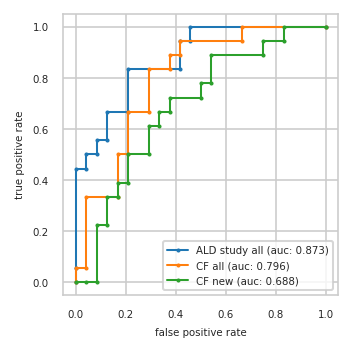

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       CF all       CF new      
             fpr   tpr    fpr   tpr    fpr   tpr
0          0.000 0.000  0.000 0.000  0.000 0.000
1          0.000 0.056  0.000 0.056  0.042 0.000
2          0.000 0.444  0.042 0.056  0.083 0.000
3          0.042 0.444  0.042 0.333  0.083 0.222
4          0.042 0.500  0.167 0.333  0.125 0.222
5          0.083 0.500  0.167 0.500  0.125 0.333
6          0.083 0.556  0.208 0.500  0.167 0.333
7          0.125 0.556  0.208 0.667  0.167 0.389
8          0.125 0.667  0.292 0.667  0.208 0.389
9          0.208 0.667  0.292 0.833  0.208 0.500
10         0.208 0.833  0.375 0.833  0.292 0.500
11         0.417 0.833  0.375 0.889  0.292 0.611
12         0.417 0.944  0.417 0.889  0.333 0.611
13         0.458 0.944  0.417 0.944  0.333 0.667
14         0.458 1.000  0.667 0.944  0.375 0.667
15         1.000 1.000  0.667 1.000  0.375 0.722
16           NaN   NaN  1.000 1.000  0.500 0.722
17           NaN   NaN    NaN   NaN  0.500 0.778
18           NaN   NaN    NaN   NaN  0.542 0.778
19           NaN   NaN    NaN   NaN  0.542 0.889
20           NaN   NaN    NaN   NaN  0.750 0.889
21           NaN   NaN    NaN   NaN  0.750 0.944
22           NaN   NaN    NaN   NaN  0.833 0.944
23           NaN   NaN    NaN   NaN  0.833 1.000
24           NaN   NaN    NaN   NaN  1.000 1.000

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,CF all,CF new
rank,,,
0,P10636-2;P10636-6,P10636-2;P10636-6,Q14894
1,K7ER15;Q9H0R4;Q9H0R4-2,B8ZZ19;H0Y3U0;P20472,P23560;P23560-2;P23560-3;P23560-4;P23560-5
2,P02741,H0Y7T8;P49418;P49418-2,P51688
3,P61981,P61981,J3KSJ8;Q9UD71;Q9UD71-2
4,P04075,C9JF17;P05090,Q96GD0
5,P14174,Q9Y2T3;Q9Y2T3-3,A0A0J9YW36;Q9NZ72;Q9NZ72-2
6,P05160,P04075,A0A0C4DGV4;E9PLX3;O43504;R4GMU8
7,P00338;P00338-3,A0A0C4DGY8;D6RA00;Q9UHY7,None
8,Q9Y2T3;Q9Y2T3-3,P63104,None


### Precision-Recall plot on test data

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/prec_recall_curve.pdf


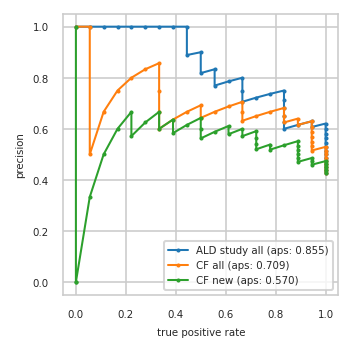

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all          CF all          CF new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.439 1.000
2          0.450 1.000     0.450 1.000     0.450 1.000
3          0.462 1.000     0.462 1.000     0.462 1.000
4          0.474 1.000     0.474 1.000     0.474 1.000
5          0.486 1.000     0.486 1.000     0.459 0.944
6          0.500 1.000     0.500 1.000     0.472 0.944
7          0.514 1.000     0.514 1.000     0.486 0.944
8          0.529 1.000     0.529 1.000     0.471 0.889
9          0.545 1.000     0.515 0.944     0.485 0.889
10         0.562 1.000     0.531 0.944     0.500 0.889
11         0.581 1.000     0.548 0.944     0.516 0.889
12         0.600 1.000     0.567 0.944     0.533 0.889
13         0.621 1.000     0.586 0.944     0.552 0.889
14         0.607 0.944     0.607 0.944     0.536 0.833
15         0.630 0.944     0.630 0.944     0.519 0.778
16         0.615 0.889     0.615 0.889     0.538 0.778
17         0.600 0.833     0.640 0.889     0.520 0.722
18         0.625 0.833     0.625 0.833     0.542 0.722
19         0.652 0.833     0.652 0.833     0.565 0.722
20         0.682 0.833     0.682 0.833     0.591 0.722
21         0.714 0.833     0.667 0.778     0.571 0.667
22         0.750 0.833     0.650 0.722     0.600 0.667
23         0.737 0.778     0.632 0.667     0.579 0.611
24         0.722 0.722     0.667 0.667     0.611 0.611
25         0.706 0.667     0.706 0.667     0.588 0.556
26         0.750 0.667     0.688 0.611     0.562 0.500
27         0.800 0.667     0.667 0.556     0.600 0.500
28         0.786 0.611     0.643 0.500     0.643 0.500
29         0.769 0.556     0.692 0.500     0.615 0.444
30         0.833 0.556     0.667 0.444     0.583 0.389
31         0.818 0.500     0.636 0.389     0.636 0.389
32         0.900 0.500     0.600 0.333     0.600 0.333
33         0.889 0.444     0.667 0.333     0.667 0.333
34         1.000 0.444     0.750 0.333     0.625 0.278
35         1.000 0.389     0.857 0.333     0.571 0.222
36         1.000 0.333     0.833 0.278     0.667 0.222
37         1.000 0.278     0.800 0.222     0.600 0.167
38         1.000 0.222     0.750 0.167     0.500 0.111
39         1.000 0.167     0.667 0.111     0.333 0.056
40         1.000 0.111     0.500 0.056     0.000 0.000
41         1.000 0.056     1.000 0.056     0.000 0.000
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/prec_recall_curve_train.pdf


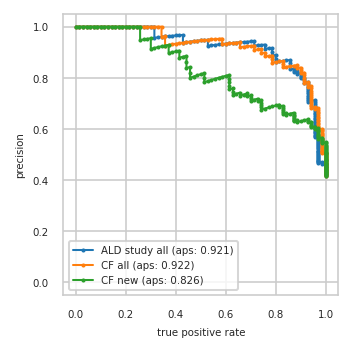

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/auc_roc_curve_train.pdf


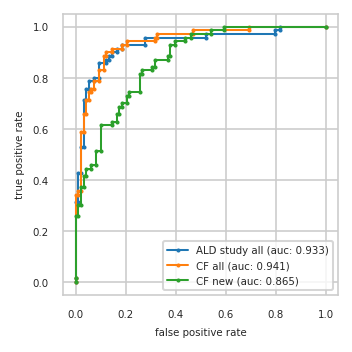

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_CF all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/results_CF all.pkl'),
 'results_CF new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/results_CF new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/auc_roc_curve_train.pdf')}